In [112]:
import skimage.io 
import skimage.segmentation
import keras
import numpy as np
from keras.applications.imagenet_utils import decode_predictions
import copy
from tensorflow.keras.applications.inception_v3 import InceptionV3
import cv2

Image to be read


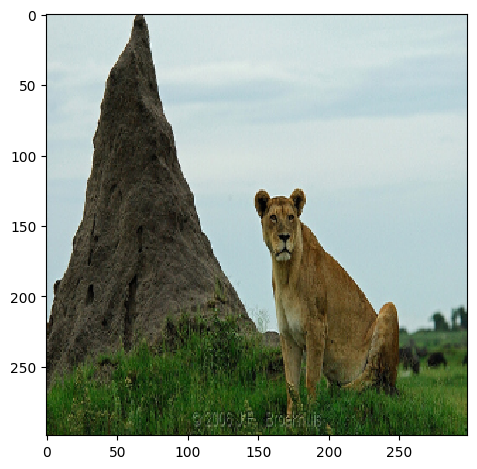

In [113]:
print("Image to be read")
Xi = skimage.io.imread("Image\lion-n02129165\\n02129165_10449.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
skimage.io.imshow(Xi)
Xi = (Xi - 0.5)*2 

In [114]:
inceptionV3_model = InceptionV3(weights="imagenet")

In [115]:
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:]) 
print(decode_predictions(preds)) #top = 5 default
R_O=preds[0]
print(R_O)

The top 5 classes of predictions are - 
1/1 [==============================] - 2s 2s/step
[[('n02129165', 'lion', 0.9215982), ('n02125311', 'cougar', 0.001936661), ('n02130308', 'cheetah', 0.0016897916), ('n02437312', 'Arabian_camel', 0.00132271), ('n02132136', 'brown_bear', 0.0010936063)]]
[3.26688642e-05 3.36789562e-05 4.95159547e-05 4.48498286e-05
 2.62971244e-05 5.28526689e-05 2.42846163e-05 4.20179567e-05
 1.60891886e-05 4.92639156e-05 3.15848192e-05 5.95798992e-05
 7.27240695e-05 7.30068205e-05 1.04420586e-04 2.69964057e-05
 8.75183396e-05 5.77030005e-05 5.65192386e-05 6.05850146e-05
 5.85005619e-05 3.75630298e-05 9.48440138e-05 7.30311294e-05
 5.45715957e-05 6.50844522e-05 5.52053352e-05 1.25960680e-04
 9.62595223e-05 8.54448444e-05 8.19185370e-05 4.25685903e-05
 3.81867394e-05 8.09244812e-05 4.30458167e-05 5.08677731e-05
 3.35443910e-05 5.34507453e-05 6.17569167e-05 8.45453542e-05
 4.15300965e-05 6.57816054e-05 1.20881894e-04 3.40671177e-05
 3.82937760e-05 8.03404546e-05 3.9495

In [116]:
preds.shape

(1, 1000)

In [117]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
print("The indices of the top 5 classes ")
top_pred_classes   

The indices of the top 5 classes 


array([291, 286, 293, 354, 294], dtype=int64)

In [118]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2) 
num_superpixels = np.unique(superpixels).shape[0]
print("The number of super pixels generated")
num_superpixels

The number of super pixels generated


60

In [119]:
def meshify_image(image, grid_size):
    h, w, c = image.shape
    superpixels = np.zeros((h, w), dtype=np.int64)

    grid_h, grid_w = grid_size, grid_size
    label = 0
    for i in range(0, h, grid_h):
        for j in range(0, w, grid_w):
            superpixels[i:i+grid_h, j:j+grid_w] = label
            label += 1

    return superpixels

In [120]:
# For meshfield grids
# superpixels =meshify_image(Xi,38)
# num_superpixels = np.unique(superpixels).shape[0]

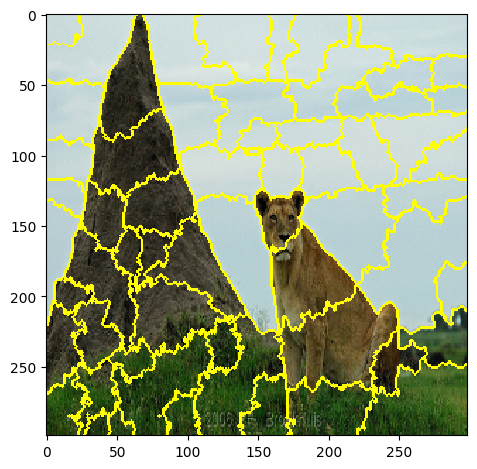

In [121]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [122]:
np.random.seed(222)
num_perturb = 500
#500 perturbations
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))#1->on
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [123]:
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image 

The perturbed image


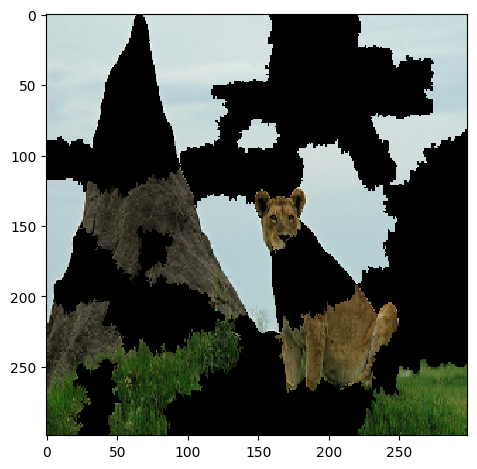

In [124]:
print("The perturbed image")
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels)) 

In [125]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)

1/1 [==============================] - 0s 150ms/step


In [126]:
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

In [127]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) 
weights.shape

(500,)

In [128]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,top_pred_classes[0]], sample_weight=weights) 
coeff = simpler_model.coef_[0] 

In [129]:
num_top_features = 5
top_features = np.argsort(coeff)[-num_top_features:] 

top_features

array([28, 18, 44, 30, 40], dtype=int64)

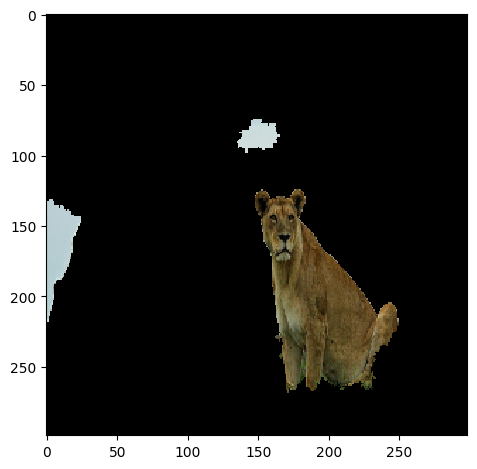

In [130]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True 
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )
img_mesh=perturb_image(Xi/2+0.5,mask,superpixels)

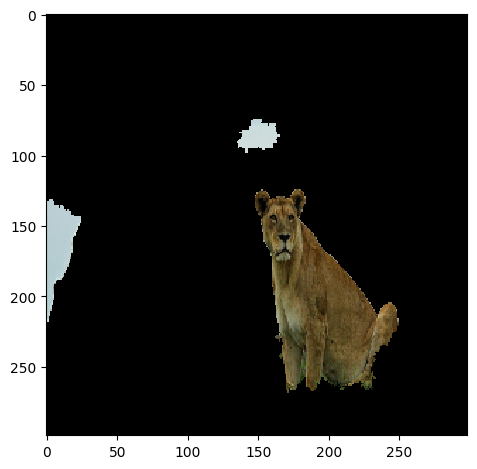

In [131]:
from skimage import img_as_ubyte

mask = np.zeros(num_superpixels)
mask[top_features] = True


perturbed_image = perturb_image(Xi/2 + 0.5, mask, superpixels)
skimage.io.imshow(perturbed_image)
perturbed_image_uint8 = img_as_ubyte(perturbed_image)
skimage.io.imsave('perturbed_image.png', perturbed_image_uint8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9986334359335306..0.8861773450429447].


1/1 [==============================] - 0s 180ms/step
EE-Score: 0.9518


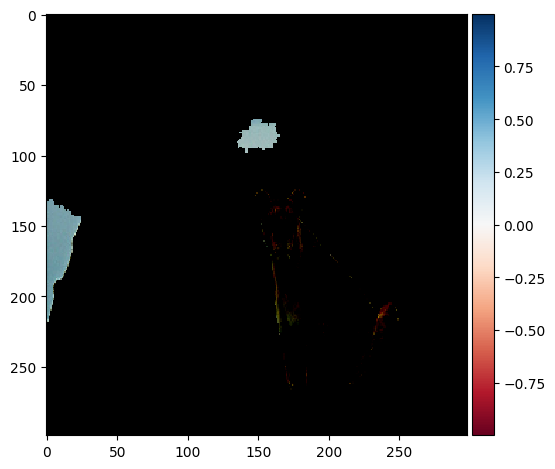

In [132]:
def calculate_ee_score(original_scores, perturbed_scores):
    return 1 - np.sum(original_scores * np.abs(original_scores - perturbed_scores))


# R_O = preds[0]  # classification score  original image


mask_image = perturb_image(Xi, mask, superpixels)
skimage.io.imshow(mask_image)
# classification scores for the perturbed image
preds_masked = inceptionV3_model.predict(mask_image[np.newaxis, :, :, :])



R_P = preds_masked[0]


ee_score = calculate_ee_score(R_O, R_P)
print(f"EE-Score: {ee_score:.4f}")

In [133]:
import matplotlib.pyplot as plt

def calculate_ee_score_for_top_n(n):
    mask = np.zeros(num_superpixels)
    top_features = np.argsort(coeff)[-n:]
    mask[top_features] = True
    mask_image = perturb_image(Xi, mask, superpixels)
    preds_masked = inceptionV3_model.predict(mask_image[np.newaxis, :, :, :])
    R_P = preds_masked[0]
    ee_score = calculate_ee_score(R_O, R_P)
    return ee_score


# EE scores for different numbers of  superpixels
ee_scores = []
num_top_superpixels = []

for n in range(1, num_superpixels + 1):
    ee_score = calculate_ee_score_for_top_n(n)
    ee_scores.append(ee_score)
    num_top_superpixels.append(n)



1/1 [==============================] - 0s 279ms/step


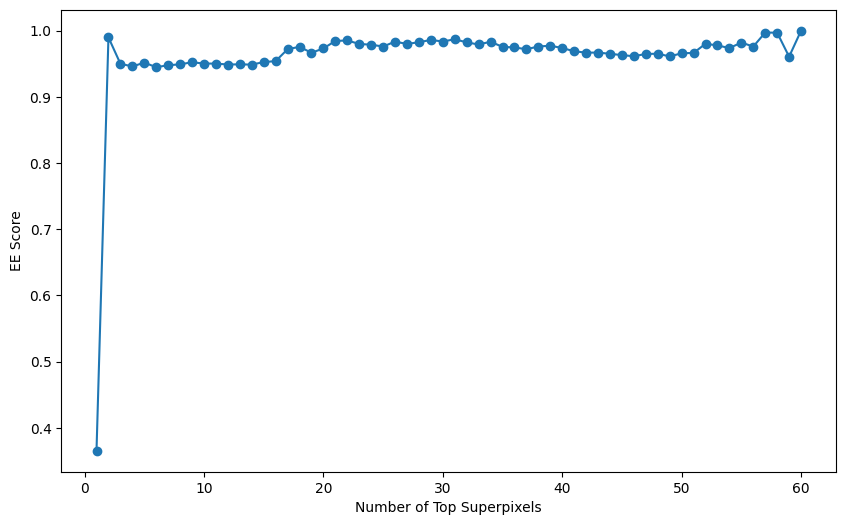

In [134]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(num_top_superpixels, ee_scores,marker='o')
plt.xlabel('Number of Top Superpixels')
plt.ylabel('EE Score')

plt.show()

In [135]:
for i in  range(len(ee_scores)):
    if ee_scores[i]>=0.90:
        num_of_segment=i
        break

[30 40]


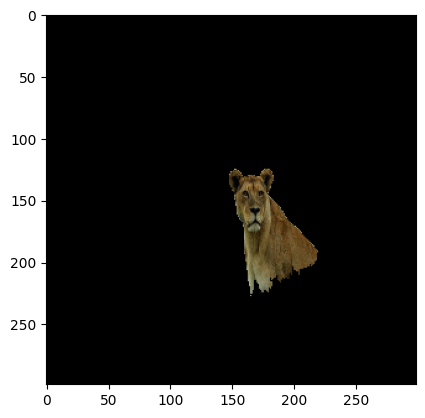

In [136]:
#pixel with thershold value >0.9
num_top_features = num_of_segment+1
top_features = np.argsort(coeff)[-num_top_features:] 

top_features
mask = np.zeros(num_superpixels)
mask[top_features] = True
print(top_features)

perturbed_image = perturb_image(Xi/2 + 0.5, mask, superpixels)
plt.imshow(perturbed_image)


In [137]:
output_filename = 'our_res.png'
skimage.io.imsave(output_filename, (perturbed_image * 255).astype(np.uint8))  # Convert to uint8 for saving

print(f"Image saved as {output_filename}")

Image saved as our_res.png


Image to be read


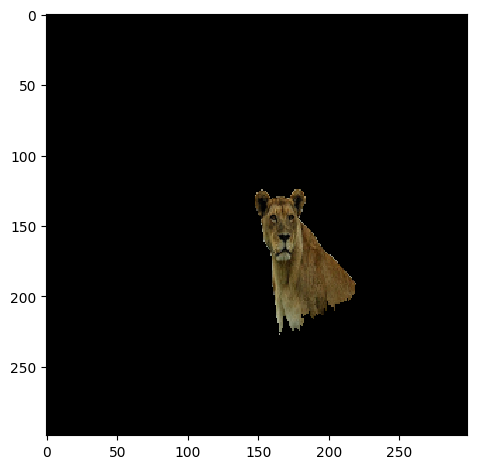

In [138]:
print("Image to be read")
resi = skimage.io.imread("our_res.png")
resi = skimage.transform.resize(resi, (299,299)) 
skimage.io.imshow(resi)
resi = (resi - 0.5)*2 


In [139]:
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(resi[np.newaxis,:,:,:]) 
print(decode_predictions(preds))
p_p=preds[0]

The top 5 classes of predictions are - 
1/1 [==============================] - 0s 185ms/step
[[('n02129165', 'lion', 0.99298614), ('n02125311', 'cougar', 0.000508078), ('n02115913', 'dhole', 0.0004208499), ('n02117135', 'hyena', 0.00027489223), ('n02115641', 'dingo', 0.00021959984)]]


[28 18 44 30 40]


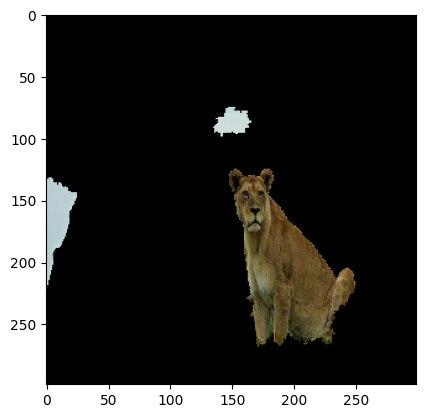

In [140]:
num_top_features = num_of_segment+1
top_features = np.argsort(coeff)[-5:] 

top_features
mask = np.zeros(num_superpixels)
mask[top_features] = True
print(top_features)

perturbed_image = perturb_image(Xi/2 + 0.5, mask, superpixels)
plt.imshow(perturbed_image)

In [141]:
top_coefficients = coeff[top_features]
sorted_top_features = top_features[np.argsort(top_coefficients)[::-1]]
sorted_top_coefficients = np.sort(top_coefficients)[::-1]
print("Top Super-pixels:", sorted_top_features)
print("Coefficients of Top Super-pixels:", sorted_top_coefficients)

Top Super-pixels: [40 30 44 18 28]
Coefficients of Top Super-pixels: [0.62338207 0.32458823 0.13632893 0.04565698 0.03844983]


In [142]:
num_pixels_in_segments = np.isin(superpixels, top_features).sum()
print(f'Number of pixels in the top {num_of_segment+1} segments: {num_pixels_in_segments}')
total_num_pixels = Xi.shape[0] * Xi.shape[1]
print(f'Total number of pixels in the entire image: {total_num_pixels}')

print(f"Important segments captures {num_pixels_in_segments*100/total_num_pixels}% area")

Number of pixels in the top 2 segments: 9305
Total number of pixels in the entire image: 89401
Important segments captures 10.408160982539345% area


[44 30 40]


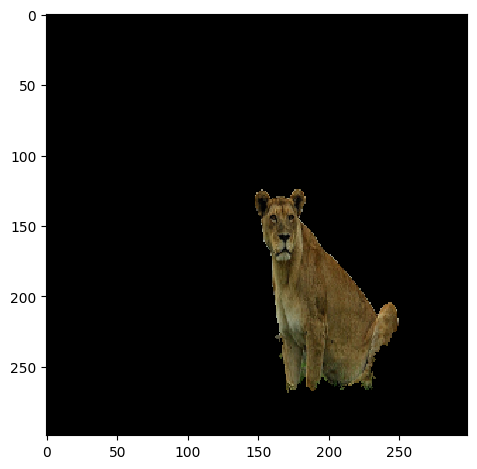

In [143]:
top_features = np.argsort(coeff)[-3:]
print(top_features)
mask = np.zeros(num_superpixels)
mask[top_features] = True

perturbed_image = perturb_image(Xi/2 + 0.5, mask, superpixels)
skimage.io.imshow(perturbed_image)

In [144]:
output_filename = 'perturbed_image_3_super.png'
skimage.io.imsave(output_filename, (perturbed_image * 255).astype(np.uint8))  # Convert to uint8 for saving

print(f"Image saved as {output_filename}")

Image saved as perturbed_image_3_super.png


Image to be read


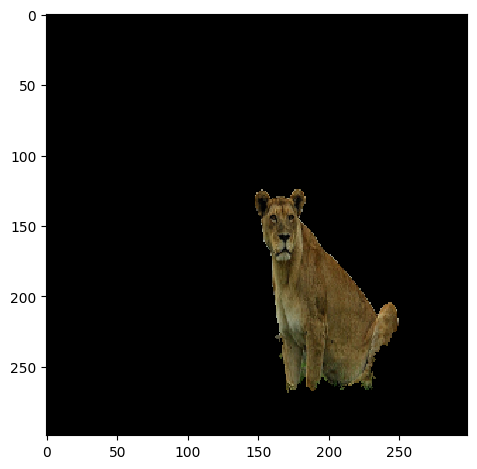

In [145]:
print("Image to be read")
pi = skimage.io.imread("perturbed_image_3_super.png")
pi = skimage.transform.resize(pi, (299,299)) 
skimage.io.imshow(pi)
pi = (pi - 0.5)*2 


In [146]:
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(pi[np.newaxis,:,:,:]) 
print(decode_predictions(preds))
p_p=preds[0]

The top 5 classes of predictions are - 
1/1 [==============================] - 0s 185ms/step
[[('n02129165', 'lion', 0.94107217), ('n02125311', 'cougar', 0.020182833), ('n02115913', 'dhole', 0.00072044384), ('n03180011', 'desktop_computer', 0.00043490608), ('n02115641', 'dingo', 0.00042184655)]]


In [147]:
ee_score = calculate_ee_score(R_O, p_p)
ee_score

0.9820072408765554

In [148]:
def get_neighbors(index, rows=8, cols=8):
    neighbors = set()

    # Current row and column based on the index
    row = (index - 1) // cols
    col = (index - 1) % cols

    # Calculate neighbor indices if they are within bounds
    if row > 0:  # Up
        neighbors.add((row - 1) * cols + col + 1)
    if row < rows - 1:  # Down
        neighbors.add((row + 1) * cols + col + 1)
    if col > 0:  # Left
        neighbors.add(row * cols + (col - 1) + 1)
    if col < cols - 1:  # Right
        neighbors.add(row * cols + (col + 1) + 1)

    return neighbors

In [149]:
nbar = set(top_features)  # Initialize 'nbar' with 'top_features' directly

new_set = set()  # Initialize an empty set for the neighbors

for i in nbar:
    neighbors = get_neighbors(i)  # Get neighbors of 'i'
    new_set.update(neighbors)  # Add the neighbors to 'new_set'

new_set.update(nbar)  # Finally, add the elements of 'nbar' to 'new_set'
new_set

{22, 29, 30, 31, 32, 36, 38, 39, 40, 43, 44, 45, 48, 52}

{32, 36, 38, 39, 40, 43, 44, 45, 48, 52, 22, 29, 30, 31}


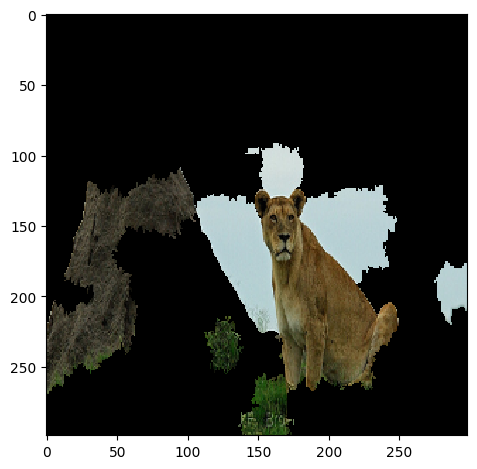

In [150]:
top_features = new_set
print(new_set)
mask = np.zeros(num_superpixels)
mask[list(new_set)] = True


perturbed_image = perturb_image(Xi/2 + 0.5, mask, superpixels)
skimage.io.imshow(perturbed_image)

In [151]:
output_filename = 'neighbour_of_3_super.png'
skimage.io.imsave(output_filename, (perturbed_image * 255).astype(np.uint8))  # Convert to uint8 for saving

print(f"Image saved as {output_filename}")

Image saved as neighbour_of_3_super.png


Image to be read


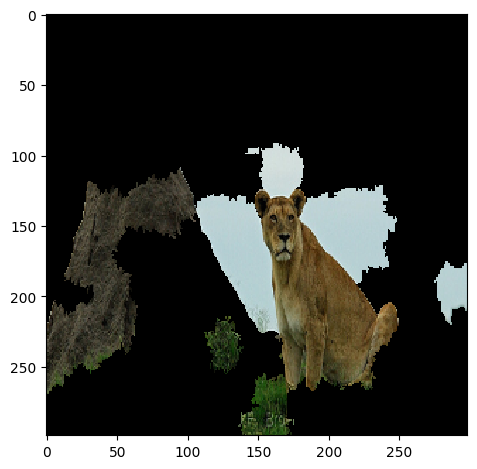

In [152]:
print("Image to be read")
ni = skimage.io.imread("neighbour_of_3_super.png")
ni = skimage.transform.resize(ni, (299,299)) 
skimage.io.imshow(ni)
ni = (ni - 0.5)*2 

In [153]:
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(ni[np.newaxis,:,:,:]) 
n_p=preds[0]
print(decode_predictions(preds))

The top 5 classes of predictions are - 
1/1 [==============================] - 0s 174ms/step
[[('n02129165', 'lion', 0.69878966), ('n02125311', 'cougar', 0.2210972), ('n02127052', 'lynx', 0.007249951), ('n02417914', 'ibex', 0.002909271), ('n02437312', 'Arabian_camel', 0.0010518569)]]


In [154]:
ee_score = calculate_ee_score(R_O, n_p)
ee_score

0.7942239046096802

In [155]:
# preds_masked = inceptionV3_model.predict(Xi[np.newaxis, :, :, :])
# R_P = preds_masked[0]
print(top_features)
rows, cols = 38, 38  # Grid dimensions
all_selected_super_pixels = set(top_features[:3])
all_element = list(top_features[:3])  
print(f"all element {all_element}")
# Initial mask and perturbed image for 3 top segment
mask = np.zeros(rows * cols, dtype=bool)
mask[list(all_selected_super_pixels)] = True
mask_image = perturb_image(Xi / 2 + 0.5, mask, superpixels)
R_P = inceptionV3_model.predict(mask_image[np.newaxis, :, :, :])[0]
print(f"EE score is {calculate_ee_score(R_O, R_P)}")
# Update loop
while calculate_ee_score(R_O, R_P) < 0.70:
    new_elements = []
    for index in all_element:
        print(f"Going index {index}")
        neighbors = get_neighbors(index)
        new_elements.extend(neighbors)
        all_selected_super_pixels.update(neighbors)
    all_element.extend(new_elements)  # Extend with new neighbors
    print(f"Length is {len(all_selected_super_pixels)}")

    # Update mask and perturbed image
    mask = np.zeros(rows * cols, dtype=bool)
    mask[list(all_selected_super_pixels)] = True
    mask_image = perturb_image(Xi / 2 + 0.5, mask, superpixels)
    R_P = inceptionV3_model.predict(mask_image[np.newaxis, :, :, :])[0]

print("No of super-pixels:", len(all_selected_super_pixels))
print("Final EE score:", calculate_ee_score(R_O, R_P))

plt.imshow(mask_image)
plt.title(f"No of superpixels {len(all_selected_super_pixels)}")
plt.show()

{32, 36, 38, 39, 40, 43, 44, 45, 48, 52, 22, 29, 30, 31}


TypeError: 'set' object is not subscriptable